# Otto Kailing -- Vital Sign Data Sonification

## Setup

In [1]:
# Authors : Otto Kailing; Gian C. Rodríguez
# Based on work by : José Constantino Sánchez Curet

# Install the necessary things before importing
!pip install saxpy
!pip install playsound
!pip install simpleaudio
!pip install -U pyo

# Importing libraries and required packages
import numpy as np

from saxpy.znorm import znorm              # to normalize the time series
from saxpy.paa import paa                  # PAA
from saxpy.sax import ts_to_string         # to convert the time series to string
from saxpy.alphabet import cuts_for_asize  # alphabet size
# from saxpy.sax import sax_via_window       # for smaller SAX words -- not currently used

from pyo import *                              # actually can synthesize sound !!!!!!!!!
import time

import matplotlib.pyplot as plt

import simpleaudio as sa                # basic sound playing package

import csv                 # to be able to import .csv (and our .dat) files
import pandas as pd        # for the readcsv function, to read in data

     |████████████████████████████████| 7.5 MB 1.7 MB/s eta 0:00:01     |██████████████████              | 4.2 MB 2.3 MB/s eta 0:00:02     |█████████████████████▍          | 5.0 MB 2.3 MB/s eta 0:00:02

WxPython is not found for the current python version.
Pyo will use a minimal GUI toolkit written with Tkinter (if available).
This toolkit has limited functionnalities and is no more
maintained or updated. If you want to use all of pyo's
GUI features, you should install WxPython, available here:
http://www.wxpython.org/



## Working with two files at once

In [2]:
# Starting with patient 40006 -- the same one I used last summer for just HR
HR = pd.read_csv("data/HR_a40006_1.dat", header = None)
MAP = pd.read_csv("data/MAP_a40006_1.dat", header = None)

# Convert both to array of floats
HR = HR[0]
MAP = MAP[0]

# Verify that they're both the same length
print("Length of HR file  =", len(HR), "\nLength of MAP file =", len(MAP))

Length of HR file  = 3865 
Length of MAP file = 3865


In [3]:
# Create backup of raw data
# !!!!!!!!!!!!! RERUNNING THIS CELL WILL DELETE THE BACKUP !!!!!!!!!!!!!
HR_raw = HR
MAP_raw = MAP

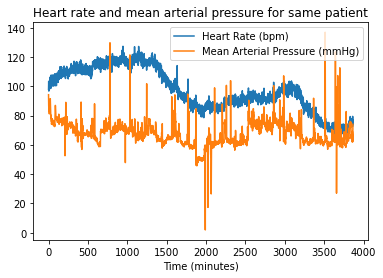

In [4]:
# Plot both raw files on the same plot
plt.plot(HR_raw, label = "Heart Rate (bpm)")
plt.plot(MAP_raw, label = "Mean Arterial Pressure (mmHg)")
plt.title("Heart rate and mean arterial pressure for same patient")
plt.xlabel("Time (minutes)")
plt.legend()
plt.show()

In [5]:
# Normalize the data
HR = znorm(HR)
MAP = znorm(MAP)

# Define PAA size (divide by 80 is what Otto used in the summer 2020 project)
#  * We want same PAA size for both files, so they end up the same length too
#  * len(HR_raw) because this will not change. In contrast, the objects
#    "HR" and "MAP" are being reassigned at every step.
paa_size = int(len(HR_raw) / 80)
print("PAA size =", paa_size)

if (paa_size != 0):
    # Apply PAA to both files
    HR = paa(HR, paa_size)
    MAP = paa(MAP, paa_size)
    # NOTE: this should not cause any problems with rerunning. Asking to run a PAA
    # of the post-PAA data with the same size should just regenerate the same data.
    
    # Verify that they're both the same length
    print("\nPost PAA:\nLength of HR  =", len(HR), "\nLength of MAP =", len(MAP))
else:
    print("Error: PAA size is 0; cannot divide by 0")


PAA size = 48

Post PAA:
Length of HR  = 48 
Length of MAP = 48


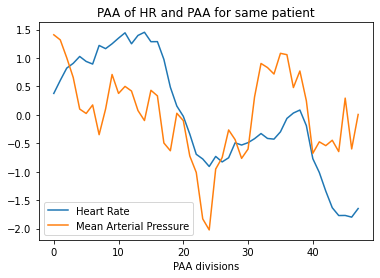

In [6]:
# Plot the files post PAA adjustment.
plt.plot(HR, label = "Heart Rate")
plt.plot(MAP, label = "Mean Arterial Pressure")
plt.title("PAA of HR and PAA for same patient")
plt.xlabel("PAA divisions")
plt.legend()
plt.show()

### Making SAX strings

In [7]:
# Define SAX alphabet size
asize = 8

# Create SAX strings of the two objects
HR_SAX = ts_to_string(HR, cuts_for_asize(asize))
MAP_SAX = ts_to_string(MAP, cuts_for_asize(asize))

# Prints the SAX strings
print("HR SAX: ", HR_SAX, "\nMAP SAX:", MAP_SAX)

HR SAX:  ffggggghhhhhhhhhhgfedcbbbbbbcccccccddeedbbaaaaaa 
MAP SAX: hhgfeeecegfffedffccedbbaabbdcbcegggggfgebccccece


## Exploring making sounds using Pyo

Pyo should allow us to generate sounds within Python, and consequently within this Jupyter notebook, rather than relying on external files (like the summer 2020 version) or an external program like EarSketch. 

However, we need to figure out how to make sounds first.

### Copying and pasting example from Pyo website
This is directly from http://ajaxsoundstudio.com/software/pyo/... It is supposed to work.

It creates a really interesting synthesized sound. however, I have no idea how to make it stop. I had to shutdown the whole kernel. We should probably look in the documentation for how to stop things.

In [23]:
# s = Server().boot()
# s.start()
# wav = SquareTable()
# env = CosTable([(0,0), (100,1), (500,.3), (8191,0)])
# met = Metro(.125, 12).play()
# amp = TrigEnv(met, table=env, dur=1, mul=.1)
# pit = TrigXnoiseMidi(met, dist='loopseg', x1=20, scale=1, mrange=(48,84))
# out = Osc(table=wav, freq=pit, mul=amp).out()

Pyo warning: Portaudio input device `MacBook Air Microphone` has fewer channels (1) than requested (2).
Pyo warning: Portmidi warning: no midi device found!
Portmidi closed.


### Copying and pasting an example from the documentation

http://ajaxsoundstudio.com/pyodoc/examples/01-intro/02-sine-tone.html

In [8]:
# # Creates and boots the server.
# # The user should send the "start" command from the GUI.
# s = Server().boot()
# # Drops the gain by 20 dB.
# s.amp = 0.1

# # Creates a sine wave player.
# # The out() method starts the processing
# # and sends the signal to the output.
# a = Sine().out()

# # Opens the server graphical interface.
# s.gui(locals())

Pyo warning: Portaudio input device `MacBook Air Microphone` has fewer channels (1) than requested (2).
Pyo warning: Portmidi warning: no midi device found!
Portmidi closed.


This opened a GUI window where I was able to start and stop playback of sound. This could be a really useful feature, especially for multivariate sonifications. However, when I hit "quit" the GUI window froze instead of quitting. 

### Controlling sounds with "time" library (not GUI)

A lot of this is us messing around with code copied from here: http://ajaxsoundstudio.com/pyodoc/gettingstarted.html

We were able to play two notes at the same time, and trigger them together!

In [15]:
s = Server().boot()
a = Sine(440, 0, 0.1).out()
e = Sine(659, 0, 0.1).out()
s.start()
time.sleep(1)
s.stop()


Pyo warning: Portmidi warning: could not open midi input 0 (Scarlett 18i8 USB): PortMidi: `Invalid device ID'
Pyo warning: Portmidi warning: could not open midi output 1 (Scarlett 18i8 USB): PortMidi: `Invalid device ID'
Pyo warning: Portmidi closed.


Now we want to test chaining sound generators together (from the same webpage).

In [16]:
s = Server().boot()
b = Adsr(attack=.01, decay=.2, sustain=.5, release=.1, dur=5, mul=.5)
a = Sine(mul=f).out()
b.play()
# e.play()   # This plays at the same time!
s.start()
time.sleep(1)
s.stop()



## First sonification of multivariate data
Ideally, we will move on to two different instrument sounds. However, we don't know how to do that yet.

For now, HR will be represented by an Amaj scale from A3 to A4.

MAP will be represented by an Amaj scale an octave higher, A4 to A5.

### Defining the instruments

Currently, it throws "invalid device ID" error for Gian Carlo's speakers every other time. Weird.

In [33]:
# Create the server thing for pyo.
s = Server().boot()

# Define two basic sine wave instruments, customizing the amplitude ("multiplier").

HR_sound = Sine(mul = 0.1).out()
MAP_sound = Sine(mul = 0.1).out()


### Playing the sonification

In [43]:
# Loops paa_size times, using an integer as index.
print("HR\tMAP")

# Starts the pyo sound player
s.start()

for x in range(0, paa_size):
    # Prints the SAX letter for both strings.
    print(HR_SAX[x], "\t", MAP_SAX[x])
    
    # Determine the correct note for HR_sound to play.
    if HR_SAX[x] == "a":
        HR_sound.setFreq(220) # A3
    elif HR_SAX[x] == "b":
        HR_sound.setFreq(246.94) # B3
    elif HR_SAX[x] == "c":
        HR_sound.setFreq(277.18) # C#4
    elif HR_SAX[x] == "d":
        HR_sound.setFreq(293.66) # D4
    elif HR_SAX[x] == "e":
        HR_sound.setFreq(329.63) # E4
    elif HR_SAX[x] == "f":
        HR_sound.setFreq(369.99) # F#4
    elif HR_SAX[x] == "g":
        HR_sound.setFreq(415.30) # G#4
    else: # "h"
        HR_sound.setFreq(440) # A4
    
    # Determine the correct note for MAP_sound to play.
    if MAP_SAX[x] == "a":
        MAP_sound.setFreq(440) # A4
    elif MAP_SAX[x] == "b":
        MAP_sound.setFreq(493.88) # B4
    elif MAP_SAX[x] == "c":
        MAP_sound.setFreq(554.37) # C#5
    elif MAP_SAX[x] == "d":
        MAP_sound.setFreq(587.33) # D5
    elif MAP_SAX[x] == "e":
        MAP_sound.setFreq(659.25) # E5
    elif MAP_SAX[x] == "f":
        MAP_sound.setFreq(739.99) # F#5
    elif MAP_SAX[x] == "g":
        MAP_sound.setFreq(830.61) # G#5
    else: # "h"
        MAP_sound.setFreq(880) # A5
    
    # Play HR_sound and MAP_sound at the same time.
    time.sleep(0.5) #half a second

# Stops the pyo sound player
s.stop()

HR	MAP
f 	 h
f 	 h
g 	 g
g 	 f
g 	 e
g 	 e
g 	 e
h 	 c
h 	 e
h 	 g
h 	 f
h 	 f
h 	 f
h 	 e
h 	 d
h 	 f
h 	 f
g 	 c
f 	 c
e 	 e
d 	 d
c 	 b
b 	 b
b 	 a
b 	 a
b 	 b
b 	 b
b 	 d
c 	 c
c 	 b
c 	 c
c 	 e
c 	 g
c 	 g
c 	 g
d 	 g
d 	 g
e 	 f
e 	 g
d 	 e
b 	 b
b 	 c
a 	 c
a 	 c
a 	 c
a 	 e
a 	 c
a 	 e


# Code from before
#### Making Pyo read multivariate string data

Let's define a function for our generated melody, so that we don't have to write it out every time.

In [23]:
def melody(sax, black_box):
    if not black_box: print("Starting playback...")
    
    # Iterate through the characters
    for char in sax:
        # Print the current letter
        if not black_box: print(char, end="")
        
        # Test for each character and play the correct note
        if char == "a":
            sound = sa.WaveObject.from_wave_file("soundFiles/a_low.wav").play()
        elif char == "b":
            sound = sa.WaveObject.from_wave_file("soundFiles/b.wav").play()
        elif char == "c":
            sound = sa.WaveObject.from_wave_file("soundFiles/db.wav").play()
        elif char == "d":
            sound = sa.WaveObject.from_wave_file("soundFiles/d.wav").play()
        elif char == "e":
            sound = sa.WaveObject.from_wave_file("soundFiles/e.wav").play()
        elif char == "f":
            sound = sa.WaveObject.from_wave_file("soundFiles/gb.wav").play()
        elif char == "g":
            sound = sa.WaveObject.from_wave_file("soundFiles/ab.wav").play()
        elif char == "h":
            sound = sa.WaveObject.from_wave_file("soundFiles/a.wav").play()
        # Wait for each sound to finish before playing next one
        sound.wait_done()
    
    if not black_box: print("\nFinished!")

Now we can enact the function "melody" on our new SAX string.

Graph of data post-PAA:


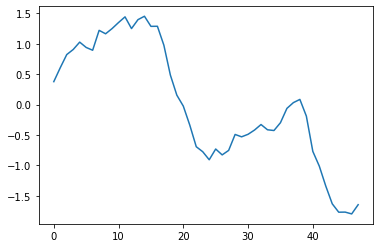

SAX string: ffggggghhhhhhhhhhgfedcbbbbbbcccccccddeedbbaaaaaa
Starting melody playback:
Finished!


In [24]:
print("Graph of data post-PAA:")
plt.plot(hr2_paa_1_25); plt.show()
print("SAX string:", hr2_sax_short)

# Calls the melody function on the new string
print("Starting melody playback:")
# # Commented out for not interrupting the demo
# melody(hr2_sax_short)
print("Finished!")

## Comparing different patients

The [PhysioNet contest](https://physionet.org/content/challenge-2009/1.0.0/) from which these data are taken (the "training" dataset) involved, as the title would suggest, "Predicting Acute Hypotensive Episodes." As such, the training data includes patients with and without periods of acute hypotension, as well as those who experienced hypotension before or after the data were collected. There are a wide variety of data. Hopefully we can see -- <em> and hear</em> -- as much.

### Function to do everything in one step

Below I will define a function for running the whole procedure (read in data --> znorm --> PAA --> SAX) on any given data file, and then another which adds the melody. (It's useful to be able to call your sound up on cue.)

In [25]:
# Take one of the data files and return the sax string
# - data_file: path to the .dat file from MIMIC II
# - black_box: FALSE if you want graphs and feedback displayed;
#              TRUE if, well, you don't.
def saxify(data_file, black_box):
    # Read in the data file.
    data = pd.read_csv(data_file, header = None)
    
    # Convert to a normal array of floats.
    hr_raw = data[0]
    
    # Graph the raw data (if desired)
    if not black_box:
        print("Raw data:")
        plt.plot(hr_raw)
        plt.show()       
    
    # Normalize
    hr_norm = znorm(hr_raw)
    
    # Apply PAA
    paa_size = len(hr_norm) // 80 # int(len(hr_norm) / paa_modifier)
    if not black_box: print("PAA size =", paa_size)
    hr_paa = paa(hr_norm, paa_size)
    # ... and graph if desired
    if not black_box:
        print("Smoothed data after PAA:"); plt.plot(hr_paa); plt.show()
    
    # Create SAX string
    hr_sax = ts_to_string(hr_paa, cuts_for_asize(8))
    # ... and display if desired
    if not black_box:
        print("SAX string:", hr_sax)
    
    # Returns the SAX string
    return hr_sax

# Just a function that calls saxify() and melody() in sequence.
def sonify(data_file, black_box):
    melody(saxify(data_file, black_box), black_box)

### Applying function to other datasets

In [26]:
# # Commented out for not interrupting the demo
# sonify("newImprovedData/HR_a40834_1.dat", black_box = False)

## Demo for presentation

Here I call saxify() and melody() separately.

Raw data:


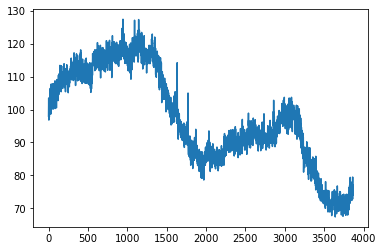

PAA size = 48
Smoothed data after PAA:


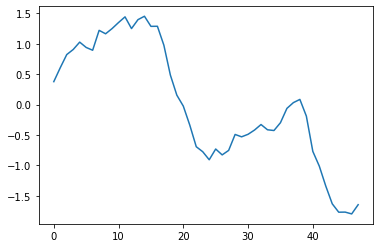

SAX string: ffggggghhhhhhhhhhgfedcbbbbbbcccccccddeedbbaaaaaa


In [27]:
sax_1 = saxify("newImprovedData/HR_a40006_1.dat", black_box = False)

In [29]:
melody(sax_1, black_box = False)

Starting playback...
ffggggghhhhhhhhhhgfedcbbbbbbcccccccddeedbbaaaaaa
Finished!


In [ ]:
sax_2 = saxify("newImprovedData/HR_a40834_1.dat", black_box = False)

In [ ]:
melody(sax_2, black_box = False)